<a href="https://colab.research.google.com/github/rururuwww/Garbage-detection/blob/master/trash_classifier_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets clone our repository initially

In [1]:
!git clone   https://github.com/chel310/Trash_classifier.git 
%cd Trash_classifier/

Cloning into 'Trash_classifier'...
remote: Enumerating objects: 28888, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 28888 (delta 51), reused 44 (delta 11), pack-reused 28760
Receiving objects: 100% (28888/28888), 946.14 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Updating files: 100% (16732/16732), done.
/content/Trash_classifier


We will be using tensorflow as our default library for transfer learning. Code uasge  was based on [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for the same

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

Lets load our training images for processing

In [3]:
batch_size = 32
img_height = 224
img_width = 224
data_root = 'dataset_augmented/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14182 files belonging to 5 classes.
Using 11346 files for training.


In [4]:
class_names = np.array(train_ds.class_names)
print('class names for predictions :',class_names)

class names for predictions : ['cardboard' 'metal' 'paper' 'plastic' 'trash']


TensorFlow Hub's conventions for image models is to expect **float** inputs in the **[0, 1]** range. Use the **Rescaling layer** to achieve this.

In [5]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [8]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [9]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
image_batch.shape

TensorShape([32, 224, 224, 3])

# Train the model

In [11]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

 To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [12]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=5,
                    callbacks=[batch_stats_callback])


Epoch 1/5
355/355 [==============================] - 39s 74ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/5
355/355 [==============================] - 14s 40ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 3/5
355/355 [==============================] - 14s 40ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 4/5
355/355 [==============================] - 14s 39ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 5/5
355/355 [==============================] - 14s 40ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

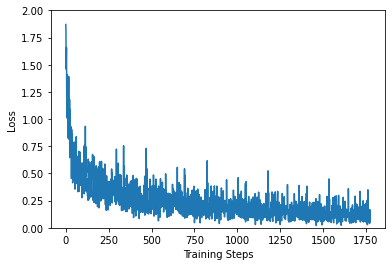

In [13]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

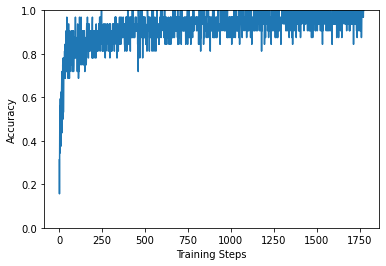

In [14]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

To redo the plot from before, first get the ordered list of class names:



In [15]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


1/1 [==============================] - 1s 519ms/step


Plot the result

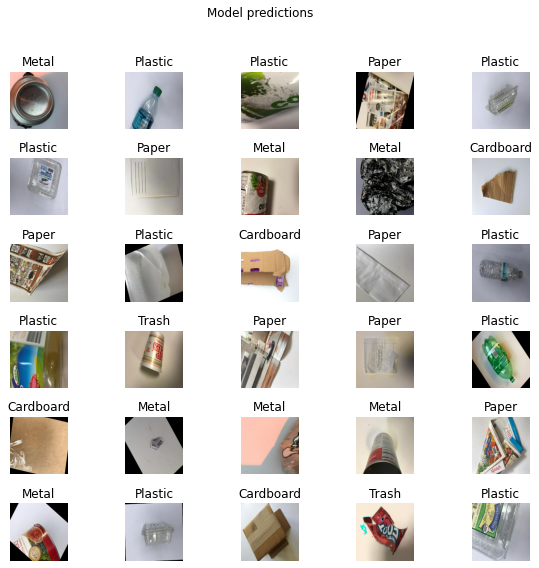

In [16]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")


## Save the Model

In [17]:
t = time.time()

export_path = "saved_models/MobileNetV2"
model.save(export_path)

export_path

'saved_models/MobileNetV2'

In [25]:
!pip install versioned-hdf5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 10.4 MB/s eta 0:00:00
  Created wheel for versioned-hdf5: filename=versioned_hdf5-1.3.13-py3-none-any.whl size=52245 sha256=5c05a06a6f0765ac43d15ce3641fd067d71183eb2b8a8721dbf4d1fd3401bfb7
  Stored in directory: /root/.cache/pip/wheels/f4/85/29/d9031e863aff36f79c170a663305bca5db51a979fca890fbee
Successfully built versioned-hdf5


In [72]:
import tensorflow as tf
import cv2
import glob
def prediction(img):
	#rescaling image
	img = img/255

	#converting to tensor
	tensor_img = tf.convert_to_tensor(img,dtype=tf.float32)

	#resizing image
	tensor_img = tf.image.resize(tensor_img,[224,224])
	tensor_img = tensor_img[tf.newaxis,...,]

	class_names = ['cardboard','metal','paper','plastic','trash']

	#predicting image
	return class_names[model.predict(tensor_img).argmax()]


if __name__ == '__main__':


	#loading model net
	model_path = 'saved_models/MobileNetV2'
	model = tf.keras.models.load_model(model_path)	

	#loading image
	image_paths = glob.glob('prediction_image/*')

	#predicting image
	for image_path in image_paths:
		img = cv2.imread(image_path)
		print('prediction for {} is :'.format(image_path.split('/')[-1]),end=' ')
		print(prediction(img))


1/1 [==============================] - 1s 735ms/step
plastic
1/1 [==============================] - 0s 44ms/step
paper
1/1 [==============================] - 0s 38ms/step
cardboard


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
from google.colab import files
files.download("/content/Trash_classifier/saved_models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
!zip -r /content/Trash_classifier/saved_models.zip /content/Trash_classifier/saved_models

  adding: content/Trash_classifier/saved_models/ (stored 0%)
  adding: content/Trash_classifier/saved_models/MobileNetV2/ (stored 0%)
  adding: content/Trash_classifier/saved_models/MobileNetV2/variables/ (stored 0%)
  adding: content/Trash_classifier/saved_models/MobileNetV2/variables/variables.index (deflated 78%)
  adding: content/Trash_classifier/saved_models/MobileNetV2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Trash_classifier/saved_models/MobileNetV2/saved_model.pb (deflated 92%)
  adding: content/Trash_classifier/saved_models/MobileNetV2/assets/ (stored 0%)
  adding: content/Trash_classifier/saved_models/MobileNetV2/assets/.ipynb_checkpoints/ (stored 0%)
  adding: content/Trash_classifier/saved_models/MobileNetV2/fingerprint.pb (stored 0%)
  adding: content/Trash_classifier/saved_models/MobileNetV2/keras_metadata.pb (deflated 80%)
